In [2]:
import wfdb
from scipy import signal
import scipy
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from scipy.signal import butter, filtfilt

def butter_bandpass_filter(input_signal, low_cutoff, high_cutoff, sampling_rate, order):
    nyq = 0.5 * sampling_rate
    low = low_cutoff / nyq
    high = high_cutoff / nyq
    numerator, denominator = butter(order, [low, high], btype='band', output='ba', analog=False, fs=None)
    filtered = filtfilt(numerator, denominator, input_signal)
    return filtered

def smoothMAconv(depth,temp, scale): # Moving average by numpy convolution
    dz = np.diff(depth) 
    N = int(scale/dz[0])
    smoothed=np.convolve(temp, np.ones((N,))/N, mode='same') 
    return smoothed

# Read Record

In [6]:
# TODO: Read all records for patients. Save fudicial features for each record/patient

samp_start = 1300
samp_end = 3200
fs = 1000
time = (samp_end - samp_start) / fs
# best start = 1300, best end = 3200
record = wfdb.rdrecord('../01.Dataset/104/s0306lre', channels=[1], sampfrom=samp_start, sampto=samp_end)
yraw = record.p_signal[:, 0]

# Get Fudicial Features

In [7]:
# STEPS 1 to 4

# 1. Bandpass (low pass / high pass)
y_lfiltered = butter_bandpass_filter(record.p_signal[:, 0], low_cutoff=1.0, high_cutoff=40.0, sampling_rate=1000, order=2)
denoised_signal = y_lfiltered

# 2. Differentiation
y_lfiltered = np.gradient(y_lfiltered)

# 3. Squaring
y_lfiltered = y_lfiltered ** 2

# 4. Window smoothing
n = 20
y_lfiltered=np.convolve(y_lfiltered, np.ones((n,))/n, mode='same')

In [8]:
# Resize for next processing
y_lfiltered = y_lfiltered * 1000

# Reduce all values close to zero to be zero
y_lfiltered[y_lfiltered < 0.1] = 0

# Get Q and S
qx = []; qy = []
sx = []; sy = []
qrs_state = False

for i in range(len(y_lfiltered)):
    if not qrs_state:
        if y_lfiltered[i] != 0:
            qx.append(i)
            qy.append(denoised_signal[i])
            qrs_state = True
    else:
        if y_lfiltered[i] == 0:
            sx.append(i)
            sy.append(denoised_signal[i])
            qrs_state = False

# Remove invalid QRS (Incomplete QRS)
if qrs_state != False:
    idx = qx.pop()
    for i in range(idx, len(y_lfiltered)):
        y_lfiltered[i] = 0
    qy.pop()

# Fix s and q (Crawl towards correct value)
for i in range(len(qx)):
    idx = qx[i]
    while(True):
        if denoised_signal[idx-1] < denoised_signal[idx]:
            qx[i] = idx-1
            qy[i] = denoised_signal[idx-1]
        else:
            break
        idx -= 1
    idx = qx[i]
    while(True):
        if denoised_signal[idx+1] < denoised_signal[idx]:
            qx[i] = idx+1
            qy[i] = denoised_signal[idx+1]
        else:
            break
        idx += 1

for i in range(len(sx)):
    idx = sx[i]
    while (True):
        if denoised_signal[idx-1] < denoised_signal[idx]:
            sx[i] = idx-1
            sy[i] = denoised_signal[idx-1]
        else:
            break
        idx -= 1
    idx = sx[i]
    while (True):
        if denoised_signal[idx+1] < denoised_signal[idx]:
            sx[i] = idx+1
            sy[i] = denoised_signal[idx+1]
        else:
            break
        idx += 1


# 5. Thresholding (Get R, any value not the peak between Q and S is set to 0)
for i in range(len(qx)):
    y_lfiltered[qx[i]:sx[i]][y_lfiltered[qx[i]:sx[i]] != max(y_lfiltered[qx[i]:sx[i]])] = 0

qx = np.array(qx); qy = np.array(qy)
sx = np.array(sx); sy = np.array(sy)

print("qrs_on: ")
print("-X: " + str(qx) + " - Y: " + str(qy))
print("qrs_off: ")
print("-X: " + str(sx) + " - Y: " + str(sy))
print(sx.shape)

# 6. Remove any peaks that are not Rs
y_lfiltered[y_lfiltered < max(y_lfiltered) * 0.7] = 0

# Retrieve R
Rx = []
Ry = []
for i in range(len(y_lfiltered)):
    if y_lfiltered[i] != 0:
        Rx.append(i)
        Ry.append(denoised_signal[i])

# Fix R (Crawl to correct value)
for i in range(len(Rx)):
    idx = Rx[i]
    while (True):
        if denoised_signal[idx-1] > denoised_signal[idx]:
            Rx[i] = idx-1
            Ry[i] = denoised_signal[idx-1]
        else:
            break
        idx -= 1
    idx = Rx[i]
    while (True):
        if denoised_signal[idx+1] > denoised_signal[idx]:
            Rx[i] = idx+1
            Ry[i] = denoised_signal[idx+1]
        else:
            break
        idx += 1

Rx = np.array(Rx)
Ry = np.array(Ry)

print("R:")
print("Rx: " + str(Rx) + " - Ry: " + str(Ry))

qrs_on: 
-X: [ 372 1285] - Y: [-0.20957147 -0.21050759]
qrs_off: 
-X: [ 485 1394] - Y: [-0.14481852 -0.1380763 ]
(2,)
R:
Rx: [ 409 1323] - Ry: [0.96183933 0.96840307]


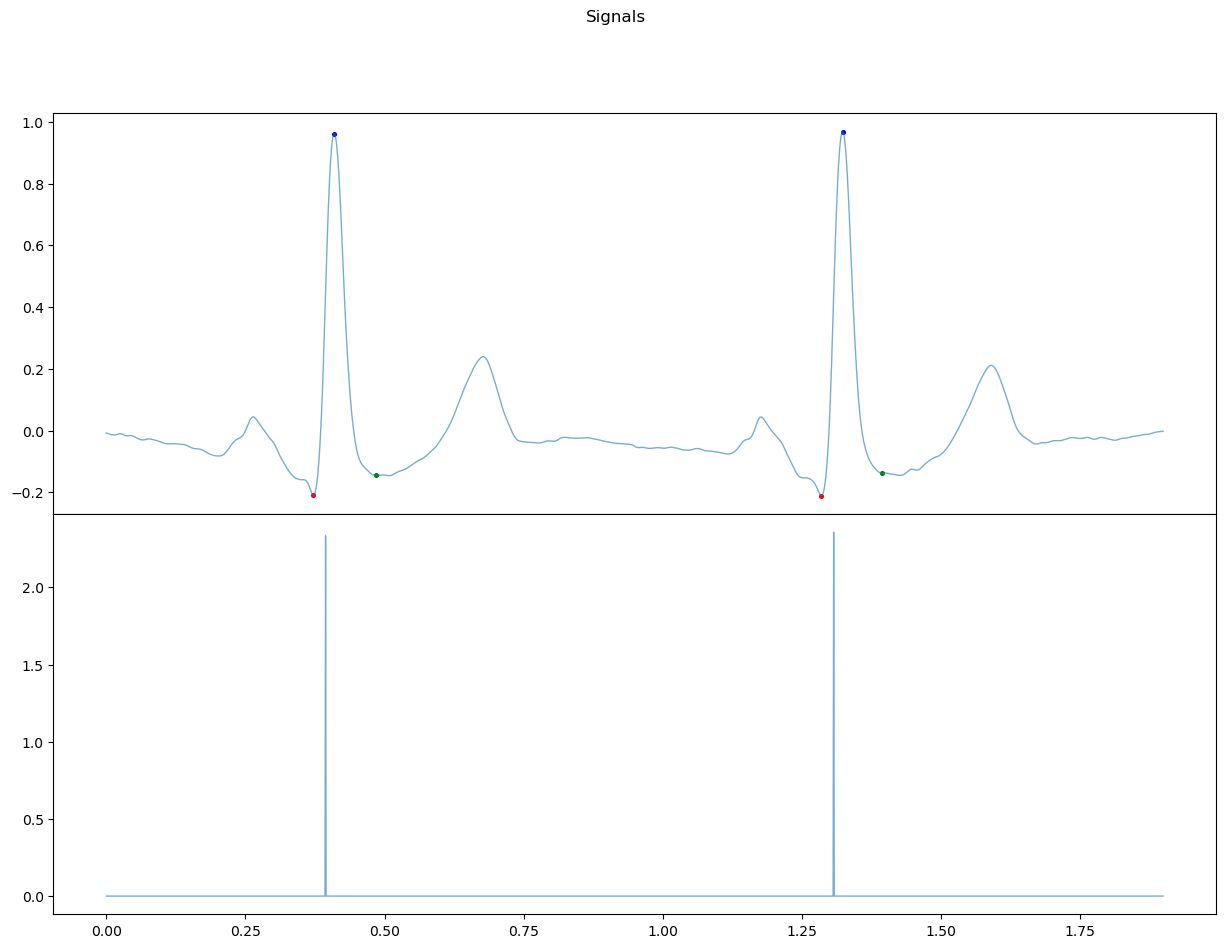

In [9]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
axs[0].scatter(Rx/fs, Ry, color="blue", s=7)

plt.show()

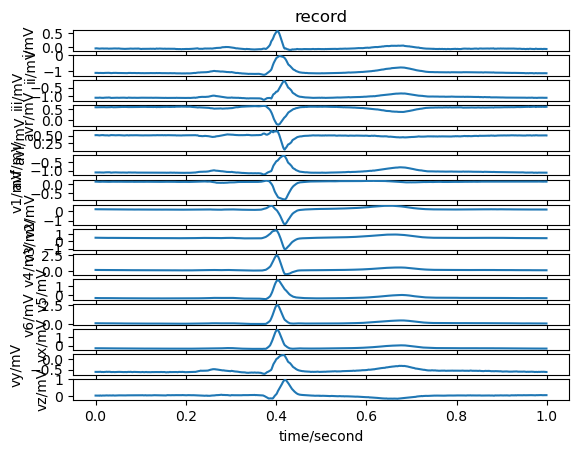

In [428]:
# Preview all channels
record = wfdb.rdrecord('104/s0306lre', sampfrom=samp_start, sampto=2300)
wfdb.plot_wfdb(record, title='record')